In [21]:
from astropy.table import Table, vstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
def calc_kcor(filter_name, redshift, colour_name, colour_value):
    """
    K-corrections calculator in Python. See http://kcor.sai.msu.ru for the 
    reference. Available filter-colour combinations must be present in the 
    `coeff` dictionary keys.

    @type   filter_name: string    
    @param  filter_name: Name of the filter to calculate K-correction for, e.g. 
                         'u', 'g', 'r' for some of the SDSS filters, or 'J2', 
                         'H2', 'Ks2' for 2MASS filters (must be present in 
                         `coeff` dictionary)
    @type      redshift: float    
    @param     redshift: Redshift of a galaxy, should be between 0.0 and 0.5 (no
                         check is made, however)
    @type   colour_name: string    
    @param  colour_name: Human name of the colour, e.g. 'u - g', 'g - r', 
                         'V - Rc', 'J2 - Ks2' (must be present in `coeff` dictionary)
    @type  colour_value: float    
    @param colour_value: Value of the galaxy's colour, specified in colour_name    
    @rtype:              float
    @return:             K-correction in specified filter for given redshift and 
                         colour
    @version:            2012
    @author:             Chilingarian, I., Melchior. A.-L., and Zolotukhin, I.
    @license:            Simplified BSD license, see http://kcor.sai.msu.ru/license.txt

    Usage example:
    
        >>> calc_kcor('g', 0.2, 'g - r', 1.1)
        0.5209713975999992
        >>> calc_kcor('Ic', 0.4, 'V - Ic', 2.0)
        0.310069919999993
        >>> calc_kcor('H', 0.5, 'H - K', 0.1)
        -0.14983142499999502
        
    """
    coeff = {

        'B_BRc': [
            [0,0,0,0],
            [-1.99412,3.45377,0.818214,-0.630543],
            [15.9592,-3.99873,6.44175,0.828667],
            [-101.876,-44.4243,-12.6224,0],
            [299.29,86.789,0,0],
            [-304.526,0,0,0],
        ],
        
        'B_BIc': [
            [0,0,0,0],
            [2.11655,-5.28948,4.5095,-0.8891],
            [24.0499,-4.76477,-1.55617,1.85361],
            [-121.96,7.73146,-17.1605,0],
            [236.222,76.5863,0,0],
            [-281.824,0,0,0],
        ],

        'H2_H2Ks2': [
            [0,0,0,0],
            [-1.88351,1.19742,10.0062,-18.0133],
            [11.1068,20.6816,-16.6483,139.907],
            [-79.1256,-406.065,-48.6619,-430.432],
            [551.385,1453.82,354.176,473.859],
            [-1728.49,-1785.33,-705.044,0],
            [2027.48,950.465,0,0],
            [-741.198,0,0,0],
        ],

        'H2_J2H2': [
            [0,0,0,0],
            [-4.99539,5.79815,4.19097,-7.36237],
            [70.4664,-202.698,244.798,-65.7179],
            [-142.831,553.379,-1247.8,574.124],
            [-414.164,1206.23,467.602,-799.626],
            [763.857,-2270.69,1845.38,0],
            [-563.812,-1227.82,0,0],
            [1392.67,0,0,0],
        ],

        'Ic_VIc': [
            [0,0,0,0],
            [-7.92467,17.6389,-15.2414,5.12562],
            [15.7555,-1.99263,10.663,-10.8329],
            [-88.0145,-42.9575,46.7401,0],
            [266.377,-67.5785,0,0],
            [-164.217,0,0,0],
        ],

        'J2_J2Ks2': [
            [0,0,0,0],
            [-2.85079,1.7402,0.754404,-0.41967],
            [24.1679,-34.9114,11.6095,0.691538],
            [-32.3501,59.9733,-29.6886,0],
            [-30.2249,43.3261,0,0],
            [-36.8587,0,0,0],
        ],

        'J2_J2H2': [
            [0,0,0,0],
            [-0.905709,-4.17058,11.5452,-7.7345],
            [5.38206,-6.73039,-5.94359,20.5753],
            [-5.99575,32.9624,-72.08,0],
            [-19.9099,92.1681,0,0],
            [-45.7148,0,0,0],
        ],

        'Ks2_J2Ks2': [
            [0,0,0,0],
            [-5.08065,-0.15919,4.15442,-0.794224],
            [62.8862,-61.9293,-2.11406,1.56637],
            [-191.117,212.626,-15.1137,0],
            [116.797,-151.833,0,0],
            [41.4071,0,0,0],
        ],

        'Ks2_H2Ks2': [
            [0,0,0,0],
            [-3.90879,5.05938,10.5434,-10.9614],
            [23.6036,-97.0952,14.0686,28.994],
            [-44.4514,266.242,-108.639,0],
            [-15.8337,-117.61,0,0],
            [28.3737,0,0,0],
        ],

        'Rc_BRc': [
            [0,0,0,0],
            [-2.83216,4.64989,-2.86494,0.90422],
            [4.97464,5.34587,0.408024,-2.47204],
            [-57.3361,-30.3302,18.4741,0],
            [224.219,-19.3575,0,0],
            [-194.829,0,0,0],
        ],

        'Rc_VRc': [
            [0,0,0,0],
            [-3.39312,16.7423,-29.0396,25.7662],
            [5.88415,6.02901,-5.07557,-66.1624],
            [-50.654,-13.1229,188.091,0],
            [131.682,-191.427,0,0],
            [-36.9821,0,0,0],
        ],

        'U_URc': [
            [0,0,0,0],
            [2.84791,2.31564,-0.411492,-0.0362256],
            [-18.8238,13.2852,6.74212,-2.16222],
            [-307.885,-124.303,-9.92117,12.7453],
            [3040.57,428.811,-124.492,-14.3232],
            [-10677.7,-39.2842,197.445,0],
            [16022.4,-641.309,0,0],
            [-8586.18,0,0,0],
        ],

        'V_VIc': [
            [0,0,0,0],
            [-1.37734,-1.3982,4.76093,-1.59598],
            [19.0533,-17.9194,8.32856,0.622176],
            [-86.9899,-13.6809,-9.25747,0],
            [305.09,39.4246,0,0],
            [-324.357,0,0,0],
        ],

        'V_VRc': [
            [0,0,0,0],
            [-2.21628,8.32648,-7.8023,9.53426],
            [13.136,-1.18745,3.66083,-41.3694],
            [-117.152,-28.1502,116.992,0],
            [365.049,-93.68,0,0],
            [-298.582,0,0,0],
        ],

        'FUV_FUVNUV': [
            [0,0,0,0],
            [-0.866758,0.2405,0.155007,0.0807314],
            [-1.17598,6.90712,3.72288,-4.25468],
            [135.006,-56.4344,-1.19312,25.8617],
            [-1294.67,245.759,-84.6163,-40.8712],
            [4992.29,-477.139,174.281,0],
            [-8606.6,316.571,0,0],
            [5504.2,0,0,0],
        ],

        'FUV_FUVu': [
            [0,0,0,0],
            [-1.67589,0.447786,0.369919,-0.0954247],
            [2.10419,6.49129,-2.54751,0.177888],
            [15.6521,-32.2339,4.4459,0],
            [-48.3912,37.1325,0,0],
            [37.0269,0,0,0],
        ],

        'g_gi': [
            [0,0,0,0],
            [1.59269,-2.97991,7.31089,-3.46913],
            [-27.5631,-9.89034,15.4693,6.53131],
            [161.969,-76.171,-56.1923,0],
            [-204.457,217.977,0,0],
            [-50.6269,0,0,0],
        ],

        'g_gz': [
            [0,0,0,0],
            [2.37454,-4.39943,7.29383,-2.90691],
            [-28.7217,-20.7783,18.3055,5.04468],
            [220.097,-81.883,-55.8349,0],
            [-290.86,253.677,0,0],
            [-73.5316,0,0,0],
        ],

        'g_gr': [
            [0,0,0,0],
            [-2.45204,4.10188,10.5258,-13.5889],
            [56.7969,-140.913,144.572,57.2155],
            [-466.949,222.789,-917.46,-78.0591],
            [2906.77,1500.8,1689.97,30.889],
            [-10453.7,-4419.56,-1011.01,0],
            [17568,3236.68,0,0],
            [-10820.7,0,0,0],
        ],

        'H_JH': [
            [0,0,0,0],
            [-1.6196,3.55254,1.01414,-1.88023],
            [38.4753,-8.9772,-139.021,15.4588],
            [-417.861,89.1454,808.928,-18.9682],
            [2127.81,-405.755,-1710.95,-14.4226],
            [-5719,731.135,1284.35,0],
            [7813.57,-500.95,0,0],
            [-4248.19,0,0,0],
        ],

        'H_HK': [
            [0,0,0,0],
            [0.812404,7.74956,1.43107,-10.3853],
            [-23.6812,-235.584,-147.582,188.064],
            [283.702,2065.89,721.859,-713.536],
            [-1697.78,-7454.39,-1100.02,753.04],
            [5076.66,11997.5,460.328,0],
            [-7352.86,-7166.83,0,0],
            [4125.88,0,0,0],
        ],

        'i_gi': [
            [0,0,0,0],
            [-2.21853,3.94007,0.678402,-1.24751],
            [-15.7929,-19.3587,15.0137,2.27779],
            [118.791,-40.0709,-30.6727,0],
            [-134.571,125.799,0,0],
            [-55.4483,0,0,0],
        ],

        'i_ui': [
            [0,0,0,0],
            [-3.91949,3.20431,-0.431124,-0.000912813],
            [-14.776,-6.56405,1.15975,0.0429679],
            [135.273,-1.30583,-1.81687,0],
            [-264.69,15.2846,0,0],
            [142.624,0,0,0],
        ],

        'J_JH': [
            [0,0,0,0],
            [0.129195,1.57243,-2.79362,-0.177462],
            [-15.9071,-2.22557,-12.3799,-2.14159],
            [89.1236,65.4377,36.9197,0],
            [-209.27,-123.252,0,0],
            [180.138,0,0,0],
        ],

        'J_JK': [
            [0,0,0,0],
            [0.0772766,2.17962,-4.23473,-0.175053],
            [-13.9606,-19.998,22.5939,-3.99985],
            [97.1195,90.4465,-21.6729,0],
            [-283.153,-106.138,0,0],
            [272.291,0,0,0],
        ],

        'K_HK': [
            [0,0,0,0],
            [-2.83918,-2.60467,-8.80285,-1.62272],
            [14.0271,17.5133,42.3171,4.8453],
            [-77.5591,-28.7242,-54.0153,0],
            [186.489,10.6493,0,0],
            [-146.186,0,0,0],
        ],

        'K_JK': [
            [0,0,0,0],
            [-2.58706,1.27843,-5.17966,2.08137],
            [9.63191,-4.8383,19.1588,-5.97411],
            [-55.0642,13.0179,-14.3262,0],
            [131.866,-13.6557,0,0],
            [-101.445,0,0,0],
        ],

        'NUV_NUVr': [
            [0,0,0,0],
            [2.2112,-1.2776,0.219084,0.0181984],
            [-25.0673,5.02341,-0.759049,-0.0652431],
            [115.613,-5.18613,1.78492,0],
            [-278.442,-5.48893,0,0],
            [261.478,0,0,0],
        ],

        'NUV_NUVg': [
            [0,0,0,0],
            [2.60443,-2.04106,0.52215,0.00028771],
            [-24.6891,5.70907,-0.552946,-0.131456],
            [95.908,-0.524918,1.28406,0],
            [-208.296,-10.2545,0,0],
            [186.442,0,0,0],
        ],

        'r_gr': [
            [0,0,0,0],
            [1.83285,-2.71446,4.97336,-3.66864],
            [-19.7595,10.5033,18.8196,6.07785],
            [33.6059,-120.713,-49.299,0],
            [144.371,216.453,0,0],
            [-295.39,0,0,0],
        ],

        'r_ur': [
            [0,0,0,0],
            [3.03458,-1.50775,0.576228,-0.0754155],
            [-47.8362,19.0053,-3.15116,0.286009],
            [154.986,-35.6633,1.09562,0],
            [-188.094,28.1876,0,0],
            [68.9867,0,0,0],
        ],

        'u_ur': [
            [0,0,0,0],
            [10.3686,-6.12658,2.58748,-0.299322],
            [-138.069,45.0511,-10.8074,0.95854],
            [540.494,-43.7644,3.84259,0],
            [-1005.28,10.9763,0,0],
            [710.482,0,0,0],
        ],

        'u_ui': [
            [0,0,0,0],
            [11.0679,-6.43368,2.4874,-0.276358],
            [-134.36,36.0764,-8.06881,0.788515],
            [528.447,-26.7358,0.324884,0],
            [-1023.1,13.8118,0,0],
            [721.096,0,0,0],
        ],

        'u_uz': [
            [0,0,0,0],
            [11.9853,-6.71644,2.31366,-0.234388],
            [-137.024,35.7475,-7.48653,0.655665],
            [519.365,-20.9797,0.670477,0],
            [-1028.36,2.79717,0,0],
            [767.552,0,0,0],
        ],

        'Y_YH': [
            [0,0,0,0],
            [-2.81404,10.7397,-0.869515,-11.7591],
            [10.0424,-58.4924,49.2106,23.6013],
            [-0.311944,84.2151,-100.625,0],
            [-45.306,3.77161,0,0],
            [41.1134,0,0,0],
        ],

        'Y_YK': [
            [0,0,0,0],
            [-0.516651,6.86141,-9.80894,-0.410825],
            [-3.90566,-4.42593,51.4649,-2.86695],
            [-5.38413,-68.218,-50.5315,0],
            [57.4445,97.2834,0,0],
            [-64.6172,0,0,0],
        ],

        'z_gz': [
            [0,0,0,0],
            [0.30146,-0.623614,1.40008,-0.534053],
            [-10.9584,-4.515,2.17456,0.913877],
            [66.0541,4.18323,-8.42098,0],
            [-169.494,14.5628,0,0],
            [144.021,0,0,0],
        ],

        'z_rz': [
            [0,0,0,0],
            [0.669031,-3.08016,9.87081,-7.07135],
            [-18.6165,8.24314,-14.2716,13.8663],
            [94.1113,11.2971,-11.9588,0],
            [-225.428,-17.8509,0,0],
            [197.505,0,0,0],
        ],

        'z_uz': [
            [0,0,0,0],
            [0.623441,-0.293199,0.16293,-0.0134639],
            [-21.567,5.93194,-1.41235,0.0714143],
            [82.8481,-0.245694,0.849976,0],
            [-185.812,-7.9729,0,0],
            [168.691,0,0,0],
        ],

    }

    c = coeff[filter_name + '_' + colour_name.replace(' - ', '')]
    kcor = 0.0

    for x, a in enumerate(c):
        for y, b in enumerate(c[x]):
            kcor += c[x][y] * redshift**x * colour_value**y
                
    return kcor
    
if __name__ == "__main__":
    import doctest
    doctest.testmod()

In [14]:
def filtrado(archivo):
    grouped = archivo.group_by('Group')

    valid_groups=[]

    for group in grouped.groups:
        if any (group['zmemb'] != 0):
            valid_groups.append(group['Group'][0])

    filtered_table = archivo[np.isin(archivo['Group'], valid_groups)]

    # Crear una función para reemplazar los valores de 'zmemb' que son 0
    def replace_zeros(group):
        non_zero_values = group['zmemb'][group['zmemb'] != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
        return group

    # Aplicar la función a cada grupo y unir los resultados
    result_groups = []
    for group in filtered_table.group_by('Group').groups:
        result_groups.append(replace_zeros(group))

    final_table = vstack(result_groups)
    
    return final_table

In [6]:
decals_raw = Table.read('GalfitM_DECALS_195.csv', format='ascii')
decals = decals_raw[decals_raw['type'] != 'PSF']

control_sample = Table.read('Control_Sample_1200.csv', format='ascii')

# Convertir la tabla de astropy a un DataFrame de pandas
df = decals.to_pandas()

# Reemplazar valores infinitos por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convertir de nuevo el DataFrame a una tabla de astropy
decals = Table.from_pandas(df)

filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals['n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    decals['e_n_' + filtro] = pd.to_numeric(decals['e_n_' + filtro], errors='coerce')
    decals['e_RE_' +filtro] = pd.to_numeric(decals['e_RE_' + filtro], errors = 'coerce')
    control_sample['n_' + filtro] = pd.to_numeric(control_sample['n_' + filtro], errors='coerce')
    control_sample['RE_' +filtro] = pd.to_numeric(control_sample['RE_' + filtro], errors = 'coerce')
    control_sample['e_n_' + filtro] = pd.to_numeric(control_sample['e_n_' + filtro], errors='coerce')
    control_sample['e_RE_' +filtro] = pd.to_numeric(control_sample['e_RE_' + filtro], errors = 'coerce')

In [15]:
decals_redshift = filtrado(decals)

In [19]:
m_i_corrected = []
m_fuv_corrected = []
m_nuv_corrected = []
m_g_corrected = []
m_r_corrected = []
m_z_corrected = []

for i in range(len(decals_redshift)):
    try:
        # Corregir FUV si los valores necesarios están presentes
        if isinstance(decals_redshift['FUV'][i], float) and isinstance(decals_redshift['NUV'][i], float):
            m_fuv = decals_redshift['FUV'][i] + calc_kcor('FUV', decals_redshift['zmemb'][i], 'FUVNUV', decals_redshift['FUV'][i] - decals_redshift['NUV'][i])
            m_fuv_corrected.append(m_fuv)
        else:
            m_fuv_corrected.append(np.nan)

        # Corregir NUV si los valores necesarios están presentes
        if isinstance(decals_redshift['NUV'][i], float) and isinstance(decals_redshift['mag_r'][i], float):
            m_nuv = decals_redshift['NUV'][i] + calc_kcor('NUV', decals_redshift['zmemb'][i], 'NUVr', decals_redshift['NUV'][i] - decals_redshift['mag_r'][i])
            m_nuv_corrected.append(m_nuv)
        else:
            m_nuv_corrected.append(np.nan)

        # Corregir mag_i si los valores necesarios están presentes
        if isinstance(decals_redshift['mag_i'][i], float) and isinstance(decals_redshift['mag_g'][i], float):
            m_i = decals_redshift['mag_i'][i] + calc_kcor('i', decals_redshift['zmemb'][i], 'gi', decals_redshift['mag_g'][i] - decals_redshift['mag_i'][i])
            m_i_corrected.append(m_i)
        else:
            m_i_corrected.append(np.nan)

        # Corregir mag_g y mag_r si los valores necesarios están presentes
        if isinstance(decals_redshift['mag_g'][i], float) and isinstance(decals_redshift['mag_r'][i], float):
            m_g = decals_redshift['mag_g'][i] + calc_kcor('g', decals_redshift['zmemb'][i], 'gr', decals_redshift['mag_g'][i] - decals_redshift['mag_r'][i])
            m_r = decals_redshift['mag_r'][i] + calc_kcor('r', decals_redshift['zmemb'][i], 'gr', decals_redshift['mag_g'][i] - decals_redshift['mag_r'][i])
            m_g_corrected.append(m_g)
            m_r_corrected.append(m_r)
        else:
            m_g_corrected.append(np.nan)
            m_r_corrected.append(np.nan)

        # Corregir mag_z si los valores necesarios están presentes
        if isinstance(decals_redshift['mag_g'][i], float) and isinstance(decals_redshift['mag_z'][i], float):
            m_z = decals_redshift['mag_z'][i] + calc_kcor('z', decals_redshift['zmemb'][i], 'gz', decals_redshift['mag_g'][i] - decals_redshift['mag_z'][i])
            m_z_corrected.append(m_z)
        else:
            m_z_corrected.append(np.nan)

    except KeyError:
        # Ignorar cualquier error de índice o clave faltante
        continue

# Añadir las columnas corregidas a la tabla
decals_redshift['m_i_corrected'] = m_i_corrected
decals_redshift['m_g_corrected'] = m_g_corrected
decals_redshift['m_r_corrected'] = m_r_corrected
decals_redshift['m_z_corrected'] = m_z_corrected
decals_redshift['FUV_corrected'] = m_fuv_corrected
decals_redshift['NUV_corrected'] = m_nuv_corrected
decals_redshift                                                                                             

Group,Gal,ID,ra,dec,type,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,m_i_corrected,m_g_corrected,m_r_corrected,m_z_corrected,FUV_corrected,NUV_corrected
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str13,float64,float64,float64,float64,float64,float64,float64,float64,str9,str9,float64,float64,str8,str13,float64,float64,int64,str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,str11,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
2,1,910,0.3129815262621921,13.11314170389291,SER,2.13987225133761,503.297,0.0038,741.8474,0.0064,34.5105,0.0196,14.9923,0.0005,1.3016,0.001,0.5896,0.0002,-19.7645,0.0295,503.297,0.0038,741.8474,0.0064,34.145,0.0157,14.4693,0.0004,1.3699,0.0007,0.5896,0.0002,-19.7645,0.0295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,503.297,0.0038,741.8474,0.0064,33.4186,0.0368,14.0924,0.0009,1.5055,0.0017,0.5896,0.0002,-19.7645,0.0295,404689,0003p130,910,0.08065711,265.1013,444.5779,0.0,644.8338,1.5809548,1.3426262,0.0,1.5098474,1.0687332,373129.8,9.556523,44885.47,-0.1056844,7462593.0,0.58465093,14950313.0,16.441471,15.880131,--,15.47638,16.136421,16.660906,15.554382,16.187887,0.56134033,--,0.40375042,--,0.3132083,13.1134167,00 01 15.17,+13 06 48.3,0.018646,--,18.5922,18.186,nan,16.463621127678817,15.900340575035468,15.482192969931877,18.57971941947987,18.192509490861546
2,2,4494,0.3331994716833093,13.11123683829803,DUP,2.13987225133761,841.8548,0.0012,719.8106,0.0007,44.2328,0.0215,13.4622,0.0003,3.5631,0.0013,0.5587,0.0001,75.4821,0.0095,841.8548,0.0012,719.8106,0.0007,46.4146,0.0161,12.6362,0.0002,3.8038,0.001,0.5587,0.0001,75.4821,0.0095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,841.8548,0.0012,719.8106,0.0007,50.7497,0.0335,11.9764,0.0004,4.2819,0.0018,0.5587,0.0001,75.4821,0.0095,404689,0003p130,4494,0.08060997,0.0,0.0,0.0,0.0,1.5825707,1.2880095,0.0,1.4925475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,--,--,--,--,--,--,--,--,--,--,--,--,0.333625,13.1111944,00 01 20.07,+13 06 40.3,0.017899,--,16.7561,16.2019,nan,nan,nan,nan,16.745557792464346,nan
2,4,1972,0.3732407814035215,13.09852691955251,SER,2.13987225133761,1111.3452,0.0166,746.5955,0.0141,36.5639,0.0625,16.3771,0.0015,1.1081,0.0026,0.2528,0.0003,49.7993,0.0245,1111.3452,0.0166,746.5955,0.0141,36.266,0.0488,15.8409,0.0013,1.0998,0.0019,0.2528,0.0003,49.7993,0.0245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1111.3452,0.0166,746.5955,0.0141,35.6739,0.1028,15.4709,0.0026,1.0833,0.0042,0.2528,0.0003,49.7993,0.0245,404689,0003p130,1972,0.08053331,96.03273,136.64732,0.0,167.82423,1.5825707,1.2880095,0.0,1.4925475,0.6900727,115520.11,8.0724945,11882.092,-0.041387293,501559.3,-0.2330424,1279131.4,17.543951,17.160997,--,16.937862,17.898212,18.694412,--,--,0.38295364,--,0.223135,--,0.373,13.0985833,00 01 29.52,+13 05 54.9,0.018646,--,19.281,19.2182,nan,17.54859585832479,17.181052419721617,16.939800860924688,19.265

In [30]:
decals_redshift.write('K_corrected_decals_data.csv', format='csv')

/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


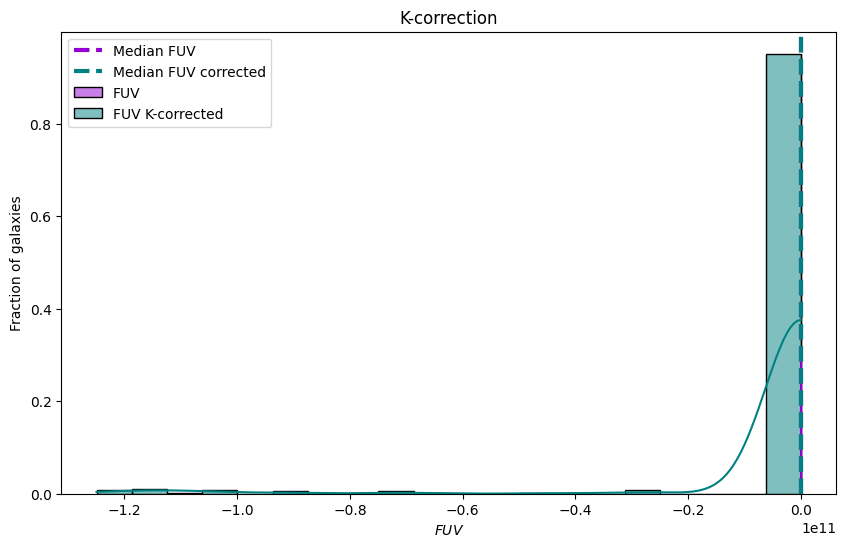

16.8646795
16.830599355770552


In [29]:
# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(decals_redshift['mag_i'][np.isfinite(decals_redshift['mag_i'])], kde=True, stat='probability', alpha=0.5, bins=20, color='darkviolet', label='FUV')
sns.histplot(decals_redshift['m_i_corrected'][np.isfinite(decals_redshift['m_i_corrected'])], kde=True, stat='probability', alpha=0.5, bins=20, color='teal', label='FUV K-corrected')

# Calcular medianas
median_x = np.nanmedian(decals_redshift['mag_i'][np.isfinite(decals_redshift['mag_i'])])
median_x_2 = np.nanmedian(decals_redshift['m_i_corrected'][np.isfinite(decals_redshift['m_i_corrected'])])

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median FUV')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median FUV corrected')

# Etiquetas y título
plt.xlabel('$FUV$')
plt.ylabel('Fraction of galaxies')
plt.title('K-correction')
plt.legend()

plt.show()

print(median_x)
print(median_x_2)